In [99]:
%matplotlib notebook

from sklearn.tree import DecisionTreeClassifier
import sparsipy

import numpy as np
import matplotlib.pyplot as plt

import copy


class AdaBoost():
    '''
        Only important functions:
            fit
            predict
            sparsify
            minimal_margin
    '''
    def __init__(self, debug=False, plot=False, pre_normalize=False, post_normalize=False):
        self.reset()
        self.debug           = debug
        self.plot            = plot 
        self.pre_normalize   = pre_normalize
        self.post_normalize  = post_normalize
        self.train_margins   = None
        
    def reset(self):
        self.estimators      = []
        self.alphas          = []
        self.sample_weight   = None
    
    def fit(self, X, y, T, plot=None, color='-go'):
        n, d = X.shape
        assert set(y) == {-1, +1}, ("Labels should be {-1, +1} and not ", set(y))
        self.reset()
        
        self.sample_weight = np.ones(n) / n # start with uniform distribution
        margins = self.step_to(X, y, T, plot=plot, color=color)
        
        return margins

    def step(self, X, y):
        # learn weak guy on weighed data set
        h_t  = DecisionTreeClassifier(max_depth=2)
        h_t.fit(X, y, sample_weight=self.sample_weight)
        eps_t = 1 - h_t.score(X, y, sample_weight=self.sample_weight)

        alpha_t = 1/2 * np.log((1-eps_t)/eps_t)

        self.estimators.append(h_t)
        self.alphas.append(alpha_t)

        predictions = h_t.predict(X)
        self.sample_weight = self.sample_weight * np.exp(- alpha_t * y * predictions )
        self.sample_weight = self.sample_weight / np.sum(self.sample_weight)
    
    def step_to(self, X, y, T, plot=None, color='-go', title=None):
        current_hypothesis = len(self.alphas)
        remaining = T - current_hypothesis
        
        # Visualization stuff
        margins = []
        xs = []
        if plot is not None and current_hypothesis != 0: 
            margins.append(self.minimal_margin(X, y))
            xs.append(current_hypothesis)
        
        # adaboost code
        for i in range(remaining): 
            self.step(X, y) 
            
            # Visualization; plot 100 steps
            if plot is not None:
                margins.append(self.minimal_margin(X, y))
                xs.append(len(self.alphas))
                plot[1].plot(xs, margins, color)
                plot[1].set_xlabel("# hypothesis")
                plot[1].set_ylabel("Minimal Margin")
                plot[0].canvas.draw()
                
        self.train_margins = margins
        return margins
        
    def predict_unsigned(self, X):
        n, d = X.shape
        pred = [self.alphas[i]*self.estimators[i].predict(X) for i in range(len(self.estimators))]
        pred = np.sum(pred, axis=0)
        assert pred.shape == (n, ), pred.shape
        return pred
    
    def predict(self, X):
        # np.sign(0)=0, handle this. 
        return np.sign(self.predict_unsigned(X))
    
    # compute the normalized margin!
    def margins(self, X, y):
        pred_unsigned = self.predict_unsigned(X)
        result_margins = pred_unsigned * y / np.sum(self.alphas)
        return result_margins
    
    def minimal_margin(self, X, y):
        return np.min(self.margins(X, y))
    
    def sparsify(self, X, y, target, plot=None, color='bo'):
        '''
        Given data X and labels y, uses discrepancy minimization to
        sparsify the hypothesis gained. How do we select the best one?
        
        Heuristic: take the one closest to 10 hypothesis (later, update this to train
                                                         less than tharget and then closest to target)
        '''
        U = self.compute_matrix(X, y)
        n, T = U.shape
        
        w = self.alphas
        if self.pre_normalize: w = w / np.sum(w)
            
        w = sparsipy.sparsify(U, w, target)
        
        for i in range(len(w)-1, 0, -1):
            current_ada = copy.deepcopy(self)
            non_zero = sum(w[i] != 0)
            if non_zero > 80: break
            
            # find the non-zero entries of w in alpha/estimators. 
            lists = []
            for j in range(w.shape[1]):
                lists.append( (w[i][j], current_ada.estimators[j]) )
            lists = sorted(lists, key = lambda x: x[0], reverse=True)
            
            # add estimators/alphas with positive weight/alpha
            current_ada.estimators = [tupple[1] for tupple in lists if tupple[0] > 0.0] 
            current_ada.alphas     = [tupple[0] for tupple in lists if tupple[0] > 0.0]

            if current_ada.post_normalize == True: 
                current_ada.alphas = list(current_ada.alphas / np.sum(current_ada.alphas))
            elif current_ada.post_normalize == "least_square":
                #current_ada.alphas = current_ada.alphas / np.sum(current_ada.alphas)
                original_w = self.alphas
                c = np.sum( w[i] * original_w) / np.sum(w[i]**2)
                w[i] = w[i] * c  
                w[i] = w[i] / np.sum(w[i])
            
            # update sample weight
            margins = current_ada.margins(X, y)
            current_ada.sample_weight = np.exp(- margins)

            print("")
            
            print("Sparsify %i gave margin: \t"%(non_zero), np.min(margins), "\t(%f)"%self.train_margins[non_zero])
            
            margins = current_ada.step_to(X, y, T, plot=plot, color=color)
            
            print("Train %i -> %i gave margin: \t"%(non_zero, T), margins[-1])            
        
    def compute_matrix(self, X, y): 
        '''
        Compute matrix U such that U_ij = h_j(x_i)
        Notice U will have size n x T
        '''
        T = len(self.alphas)
        n, d = X.shape
        U = np.zeros( (n, T) )
        
        for i in range(T):
            U[:, i] = self.estimators[i].predict(X)
            
        return U
    
    def score(self, X, y):
        n, d = X.shape
        pred = self.predict(X)
        return sum(pred == y) / n

def initialize_experiment(X, y, T):
    ada = AdaBoost(debug=False, pre_normalize=False, post_normalize=False)
    
    fig_ax_tupple = plt.subplots(1, 1, figsize=(10,5)) 
    fig_ax_tupple[1].set_xscale("log")
    
    title = "Initial AdaBoost, T=" + str(T)
    fig_ax_tupple[1].set_title(title)
    
    margins = ada.fit(X, y, T, plot=fig_ax_tupple, color='-g')
    
    return ada, margins
    
# reuse ada to be more fair between experiments. 
def experiment(ada, margins, pre_normalize, post_normalize, T):
    fig_ax_tupple = plt.subplots(1, 1, figsize=(10,5)) 
    fig_ax_tupple[1].set_xscale("log")
    
    title = "pre_normalize: " + str(pre_normalize) + ", post_normalize: " +str(post_normalize) + ", T: " + str(T)
    fig_ax_tupple[1].set_title(title)
    
    fig_ax_tupple[1].plot(range(1, T+1), margins, '-g')

    print("Fit %i directly: \t\t"%T, margins[-1]) 
    ada.sparsify(X, y, 10, plot=fig_ax_tupple, color='-b')
    fig_ax_tupple[0].savefig("figures/" + title)
    fig_ax_tupple[0].canvas.draw()

# Sanity check: compare with SKlearn

In [133]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1

T = 100
sklearn_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),  algorithm="SAMME", n_estimators=T)
sklearn_ada.fit(X, y)

alex_ada = AdaBoost()
alex_ada.fit(X, y, T)

print("Sklearn: \t", sklearn_ada.score(X, y))
print("Alex: \t\t", alex_ada.score(X, y)) 

Sklearn: 	 0.941
Alex: 		 0.941


# Plot minimal margin during fit

<IPython.core.display.Javascript object>


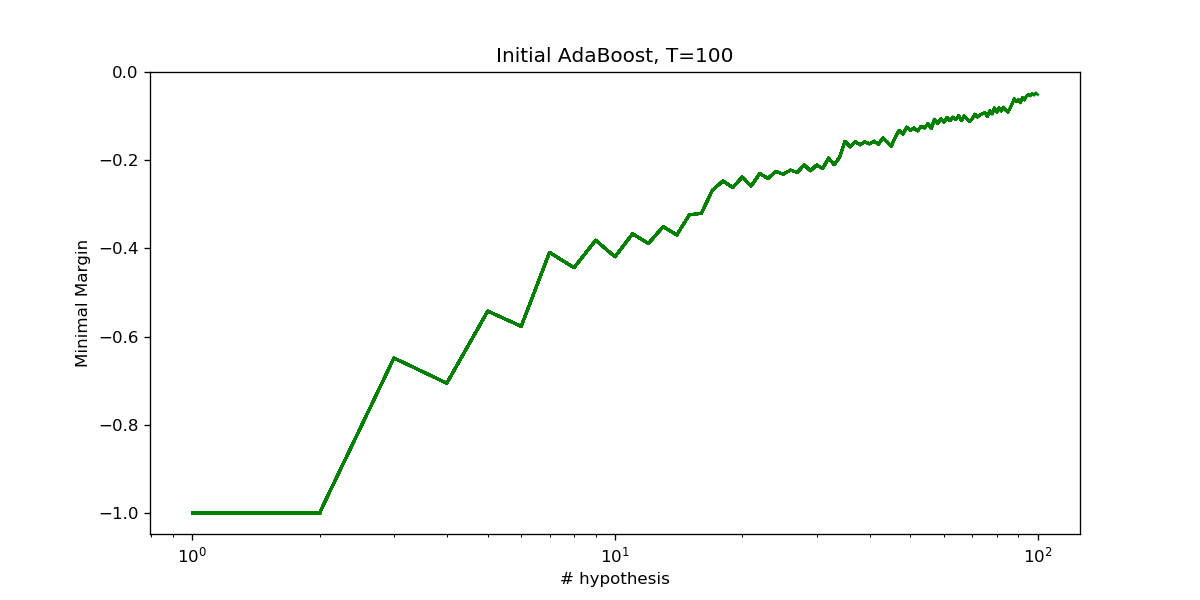

/home/ubudevml/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


In [108]:
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1
T = 100

alex_ada, margins = initialize_experiment(X, y, T) # init my adaboost with plot, then fit. 

# Simple sparify experiment

<IPython.core.display.Javascript object>


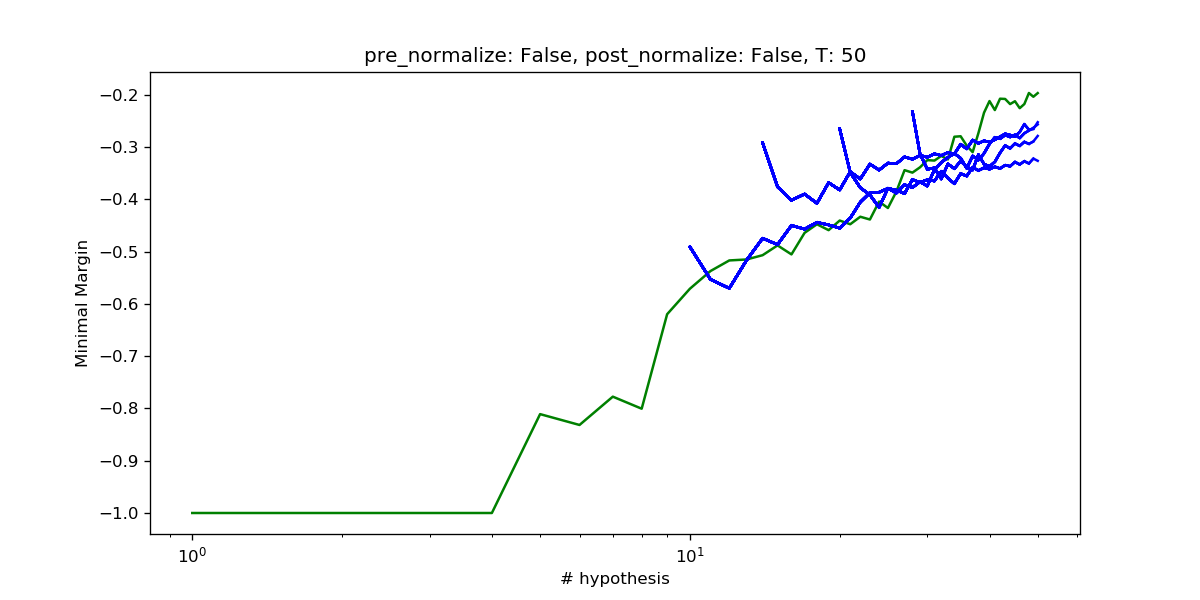

Fit 50 directly: 		 -0.196970973913
Sparsify 10 gave margin: 	 -0.491007114307 	(-0.537284)
Train 10 -> 50 gave margin: 	 -0.326510822927

Sparsify 14 gave margin: 	 -0.291983614282 	(-0.488237)
Train 14 -> 50 gave margin: 	 -0.252658329084

Sparsify 20 gave margin: 	 -0.265249963927 	(-0.447757)
Train 20 -> 50 gave margin: 	 -0.256947563388

Sparsify 28 gave margin: 	 -0.232165461414 	(-0.338903)
Train 28 -> 50 gave margin: 	 -0.278904467663



In [137]:
T = 100

experiment(ada, margins, True, True, T)

# Big experiment

<IPython.core.display.Javascript object>


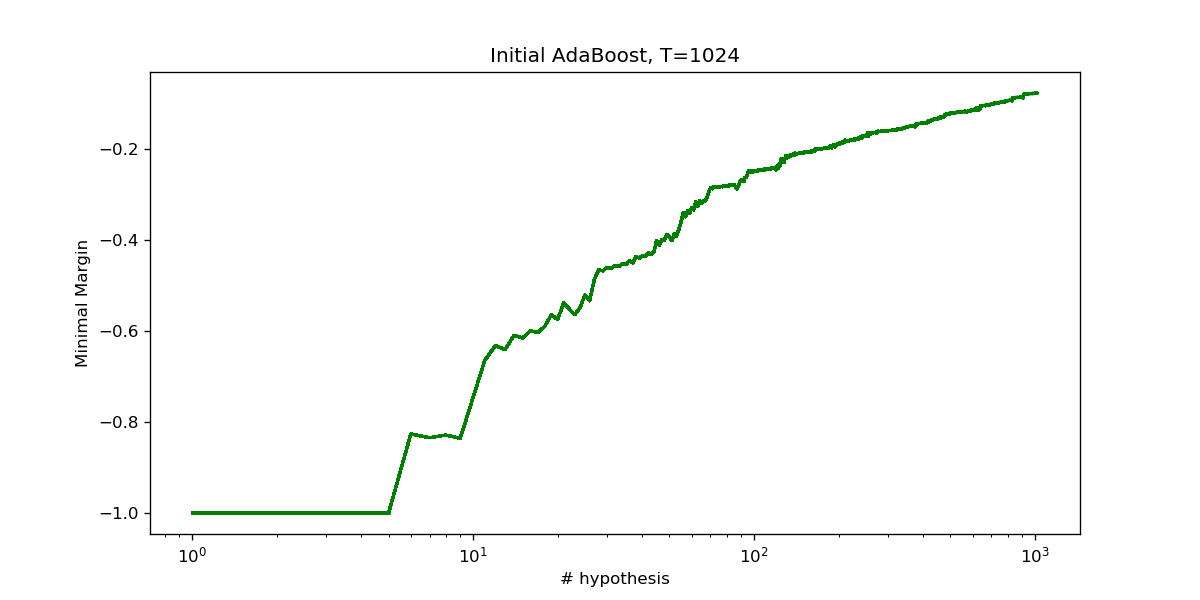

/home/ubudevml/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


<IPython.core.display.Javascript object>


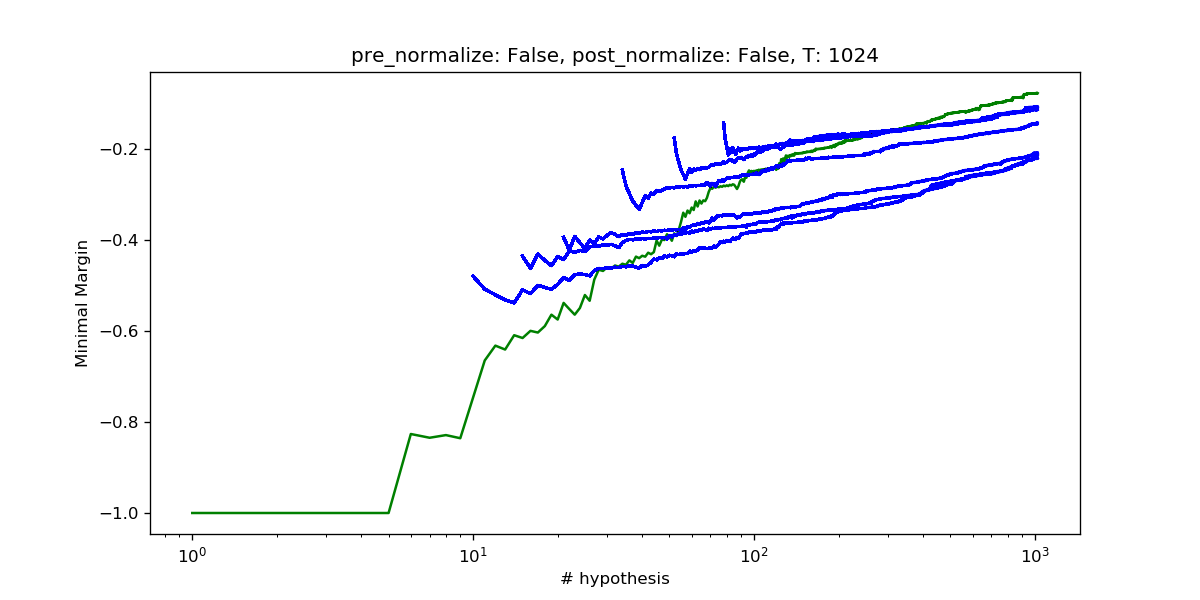

Fit 1024 directly: 		 -0.0769712761641
Sparsify 10 gave margin: 	 -0.479609269982 	(-0.664674)
Train 10 -> 1024 gave margin: 	 -0.213208633122

Sparsify 15 gave margin: 	 -0.435260429173 	(-0.599598)
Train 15 -> 1024 gave margin: 	 -0.220171487589

Sparsify 21 gave margin: 	 -0.394245872396 	(-0.551653)
Train 21 -> 1024 gave margin: 	 -0.208543166939

Sparsify 34 gave margin: 	 -0.246360031463 	(-0.454348)
Train 34 -> 1024 gave margin: 	 -0.142134545449

Sparsify 52 gave margin: 	 -0.175953171235 	(-0.391140)
Train 52 -> 1024 gave margin: 	 -0.113241453983

Sparsify 78 gave margin: 	 -0.142847449425 	(-0.281761)
Train 78 -> 1024 gave margin: 	 -0.107328289246



<IPython.core.display.Javascript object>


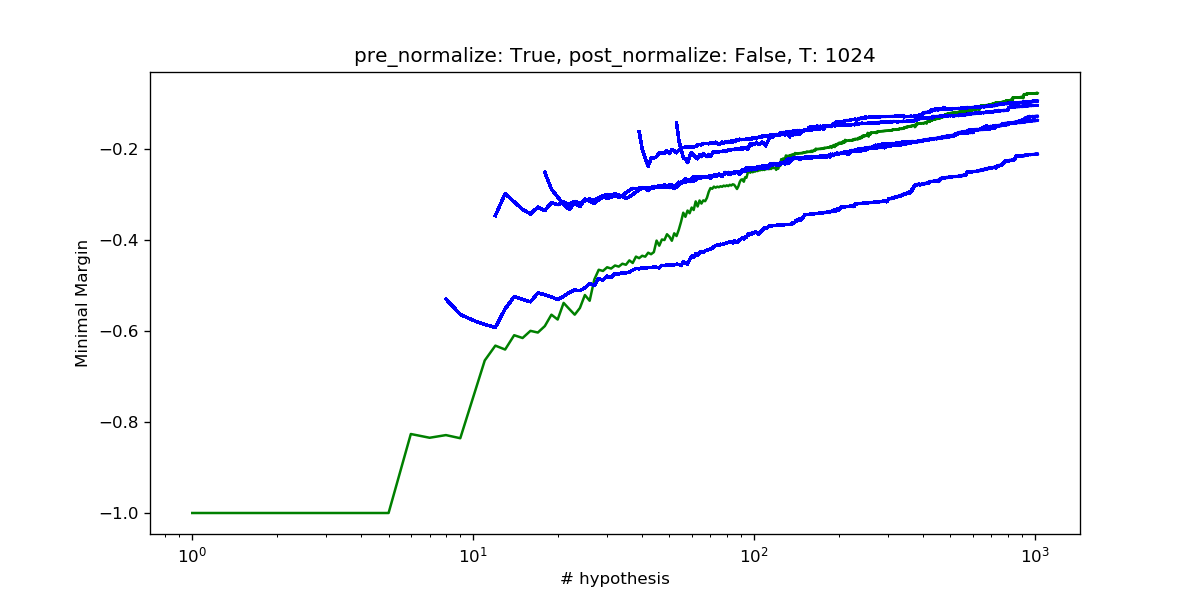

Fit 1024 directly: 		 -0.0769712761641
Sparsify 8 gave margin: 	 -0.529669528169 	(-0.835630)
Train 8 -> 1024 gave margin: 	 -0.210848479017

Sparsify 12 gave margin: 	 -0.346144058937 	(-0.640670)
Train 12 -> 1024 gave margin: 	 -0.12768569806

Sparsify 18 gave margin: 	 -0.251137029821 	(-0.564025)
Train 18 -> 1024 gave margin: 	 -0.13641286998

Sparsify 39 gave margin: 	 -0.161361108108 	(-0.434526)
Train 39 -> 1024 gave margin: 	 -0.10390259204

Sparsify 53 gave margin: 	 -0.141406707266 	(-0.377019)
Train 53 -> 1024 gave margin: 	 -0.0935134501762



<IPython.core.display.Javascript object>


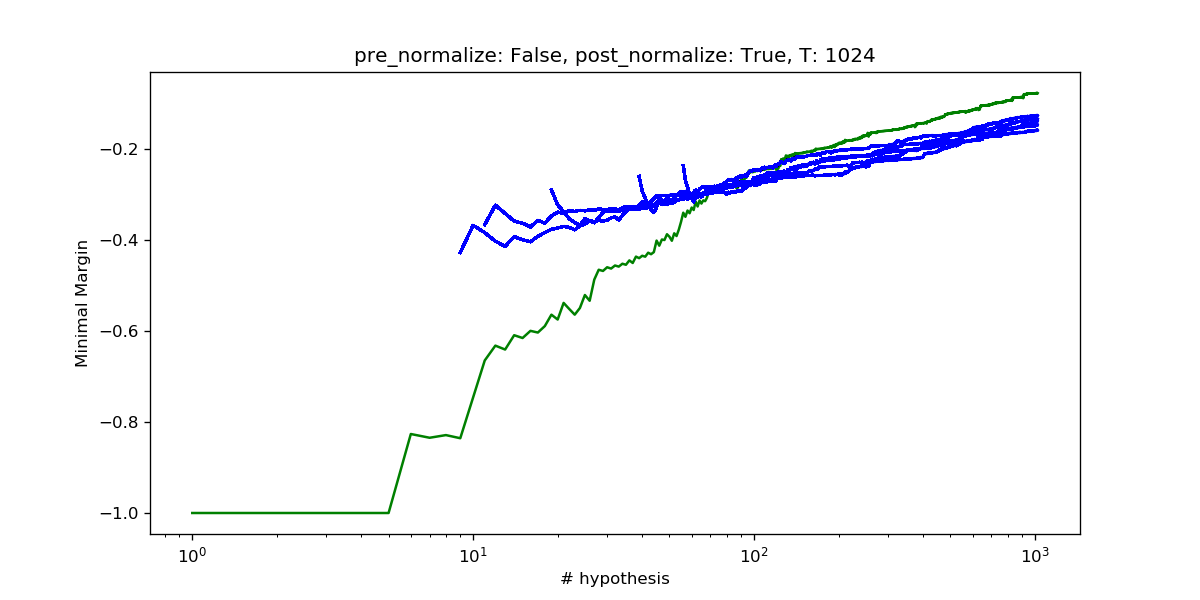

Fit 1024 directly: 		 -0.0769712761641
Sparsify 9 gave margin: 	 -0.427523537432 	(-0.745567)
Train 9 -> 1024 gave margin: 	 -0.158947686809

Sparsify 11 gave margin: 	 -0.365973127275 	(-0.632066)
Train 11 -> 1024 gave margin: 	 -0.13674997808

Sparsify 19 gave margin: 	 -0.290053103217 	(-0.574703)
Train 19 -> 1024 gave margin: 	 -0.146911250643

Sparsify 39 gave margin: 	 -0.260183675704 	(-0.434526)
Train 39 -> 1024 gave margin: 	 -0.133193598445

Sparsify 56 gave margin: 	 -0.236591366128 	(-0.348907)
Train 56 -> 1024 gave margin: 	 -0.126278614767



<IPython.core.display.Javascript object>


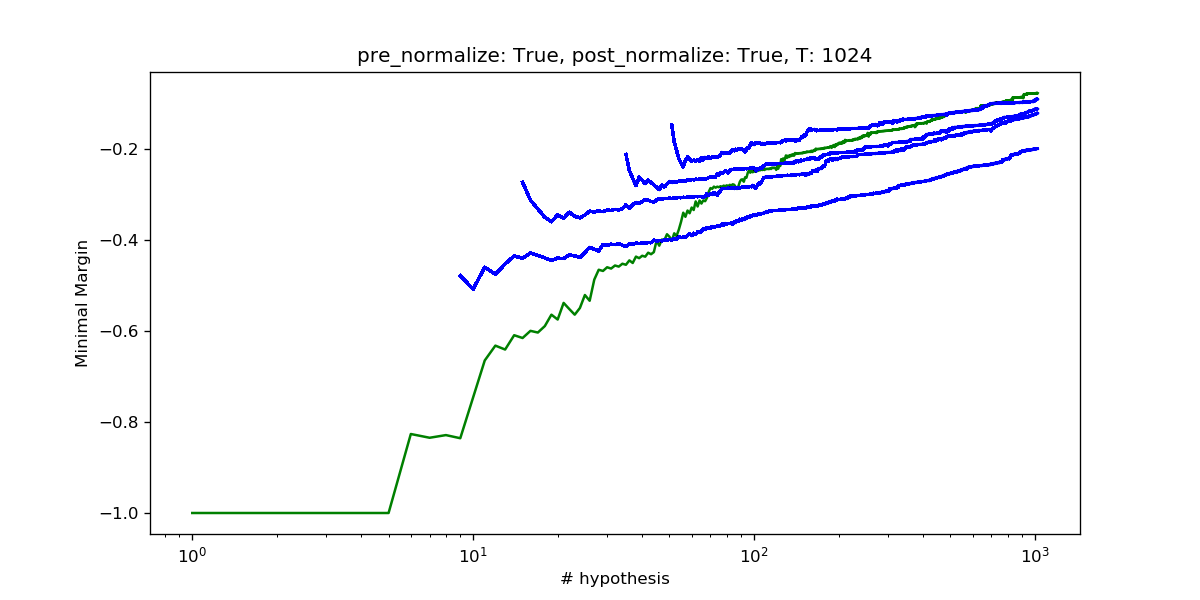

Fit 1024 directly: 		 -0.0769712761641
Sparsify 9 gave margin: 	 -0.478008988639 	(-0.745567)
Train 9 -> 1024 gave margin: 	 -0.199026974095

Sparsify 15 gave margin: 	 -0.272867402467 	(-0.599598)
Train 15 -> 1024 gave margin: 	 -0.121182163438

Sparsify 35 gave margin: 	 -0.211611137854 	(-0.444670)
Train 35 -> 1024 gave margin: 	 -0.111791754966

Sparsify 51 gave margin: 	 -0.147200386049 	(-0.385162)
Train 51 -> 1024 gave margin: 	 -0.0903537825194



<IPython.core.display.Javascript object>


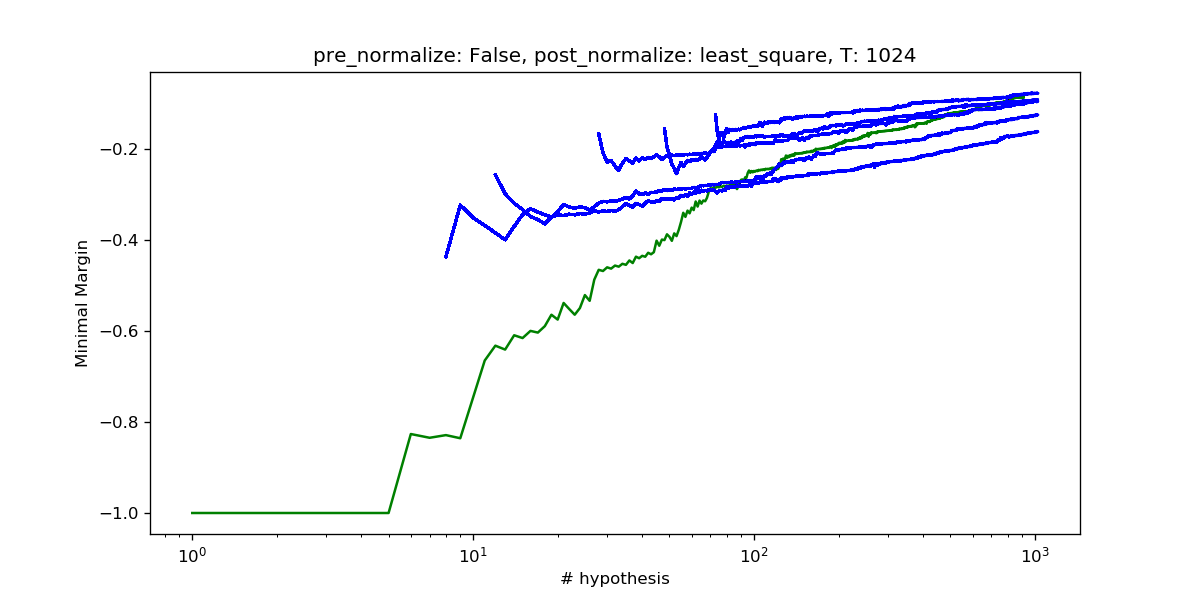

Fit 1024 directly: 		 -0.0769712761641
Sparsify 8 gave margin: 	 -0.436701552904 	(-0.835630)
Train 8 -> 1024 gave margin: 	 -0.161721060466

Sparsify 12 gave margin: 	 -0.256275615426 	(-0.640670)
Train 12 -> 1024 gave margin: 	 -0.12445958221

Sparsify 28 gave margin: 	 -0.166028420189 	(-0.467907)
Train 28 -> 1024 gave margin: 	 -0.0914548367572

Sparsify 48 gave margin: 	 -0.15510929867 	(-0.387214)
Train 48 -> 1024 gave margin: 	 -0.0940708874594

Sparsify 73 gave margin: 	 -0.123883051173 	(-0.282661)
Train 73 -> 1024 gave margin: 	 -0.0771625445905



<IPython.core.display.Javascript object>


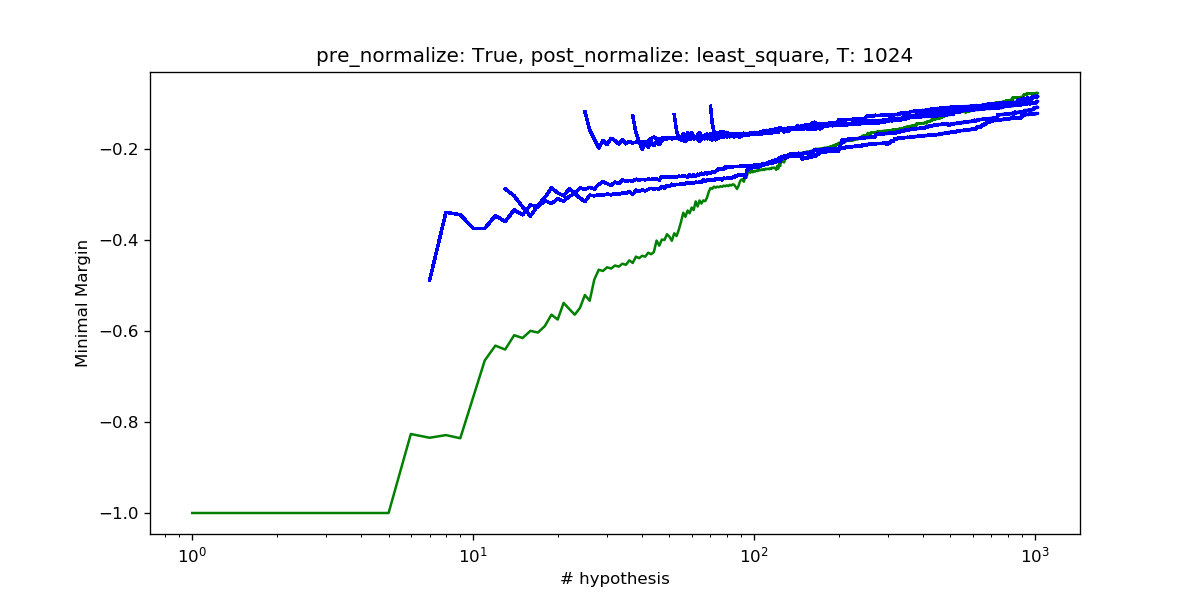

Fit 1024 directly: 		 -0.0769712761641
Sparsify 7 gave margin: 	 -0.488320274475 	(-0.828746)
Train 7 -> 1024 gave margin: 	 -0.108191905439

Sparsify 13 gave margin: 	 -0.287361015281 	(-0.609186)
Train 13 -> 1024 gave margin: 	 -0.121586959503

Sparsify 25 gave margin: 	 -0.117685310076 	(-0.533466)
Train 25 -> 1024 gave margin: 	 -0.0835841619695

Sparsify 37 gave margin: 	 -0.126553576062 	(-0.436390)
Train 37 -> 1024 gave margin: 	 -0.095094688116

Sparsify 52 gave margin: 	 -0.123947145745 	(-0.391140)
Train 52 -> 1024 gave margin: 	 -0.0848428311293

Sparsify 70 gave margin: 	 -0.105897793735 	(-0.287346)
Train 70 -> 1024 gave margin: 	 -0.0850812908176



In [139]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

X, y = make_classification(4000, 5, n_classes=2)
y = y*2-1

T = 1024

ada, margins = initialize_experiment(X, y, T)

# OBS: I don't re-use sparsification between guys sharing pre_norm=True/False 
experiment(ada, margins, False, False, T) 
experiment(ada, margins, True, False, T)
experiment(ada, margins, False, True, T)
experiment(ada, margins, True, True, T)
experiment(ada, margins, False, "least_square", T)
experiment(ada, margins, True, "least_square", T)